# W207 Final Project - Zillow Housing Data
We examined a dataset from Zillow that was posted to Kaggle in 2017. The dataset includes many features from houses available in the Zillow catalogue. The task is to predict what the $logerror$ of the Zillow's estimate of the house's sale price ($Zestimate$) against the actual sale price of the house ($SalePrice$). The $logerror$ is defined as follows:

$$ logerror = log(Zestimate) - log(SalePrice) $$

The competition was evaluated on the submission's Mean Absolute Error($MAE$). This is calculated as follows:

$$ MAE = \frac{\sum_{i=1}^n \left|y_i - \hat{y}_i\right|}{n} $$

Where $n$ is the number of entries in the dataset, $y_i$ is the actual value of the datapoint $i$, and $\hat{y}_i$ is the predicted value of the datapoint $i$.

## Setup
### Import Required Libraries

In [1]:
from time import time
import re as re
from datetime import datetime
import math

import numpy as np
from numpy import errstate,isneginf
from scipy import stats
import pandas as pd
from pandas.plotting import register_matplotlib_converters; register_matplotlib_converters()
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

from scipy import stats
import reverse_geocoder as rg # https://github.com/thampiman/reverse-geocoder
import seaborn as sns
sns.set(style = 'white')

import gauntlet


%matplotlib inline

### Read in Data

In [2]:
train_2016 = pd.read_csv("train_2016_v2.csv")
properties_2016 = pd.read_csv("properties_2016.csv")

/Users/austindoolittle/miniconda3/envs/jupyter3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exploratory Data Analysis

First we look at the housing features and label dataframes

In [3]:
# look at properties 2016 dataframe
properties_2016.describe(include='all').transpose().sort_values(by='count')

count unique   top     freq         mean  \
storytypeid                          1624    NaN   NaN      NaN            7   
basementsqft                         1628    NaN   NaN      NaN      646.883   
yardbuildingsqft26                   2647    NaN   NaN      NaN      278.297   
fireplaceflag                        5163      1  True     5163          NaN   
architecturalstyletypeid             6061    NaN   NaN      NaN      7.20261   
typeconstructiontypeid               6747    NaN   NaN      NaN      5.99956   
finishedsquarefeet13                 7672    NaN   NaN      NaN       1178.9   
buildingclasstypeid                 12629    NaN   NaN      NaN      3.72595   
decktypeid                          17096    NaN   NaN      NaN           66   
finishedsquarefeet6                 22001    NaN   NaN      NaN      2414.34   
poolsizesum                         27960    NaN   NaN      NaN      519.711   
pooltypeid2                         32075    NaN   NaN      NaN            1   
pooltypeid10                        36939    NaN   NaN      NaN            1   
taxdelinquencyflag                  56462      1     Y    56462          NaN   
taxdelinquencyyear                  56464    NaN   NaN      NaN      13.8924   
hashottuborspa                      69014      1  True    69014          NaN   
yardbuildingsqft17                  80355    NaN   NaN      NaN      319.803   
finishedsquarefeet15               190798    NaN   NaN      NaN      2739.19   
finishedsquarefeet50               202717    NaN   NaN      NaN      1388.94   
finishedfloor1squarefeet           202717    NaN   NaN      NaN      1380.63   
threequarterbathnbr                311631    NaN   NaN      NaN      1.01001   
fireplacecnt                       312637    NaN   NaN      NaN      1.16871   
pooltypeid7                        485459    NaN   NaN      NaN            1   
poolcnt                            517534    NaN   NaN      NaN            1   
numberofstories                    682069    NaN   NaN      NaN      1.40146   
airconditioningtypeid              811519    NaN   NaN      NaN      1.93117   
garagecarcnt                       883267    NaN   NaN      NaN      1.82352   
garagetotalsqft                    883267    NaN   NaN      NaN      383.769   
regionidneighborhood           1.1564e+06    NaN   NaN      NaN       193476   
heatingorsystemtypeid          1.8064e+06    NaN   NaN      NaN      4.01205   
buildingqualitytypeid         1.93849e+06    NaN   NaN      NaN      5.78479   
unitcnt                       1.97749e+06    NaN   NaN      NaN      1.18117   
propertyzoningdesc                1978629   5638  LAR1   275029          NaN   
lotsizesquarefeet             2.70912e+06    NaN   NaN      NaN      22822.8   
finishedsquarefeet12          2.70918e+06    NaN   NaN      NaN         1760   
fullbathcnt                   2.85630e+06    NaN   NaN      NaN      2.24417   
calculatedbathnbr             2.85630e+06    NaN   NaN      NaN      2.29926   
censustractandblock           2.91009e+06    NaN   NaN      NaN  6.04843e+13   
landtaxvaluedollarcnt         2.91748e+06    NaN   NaN      NaN       252478   
regionidcity                  2.92237e+06    NaN   NaN      NaN      34993.4   
yearbuilt                     2.92529e+06    NaN   NaN      NaN      1964.26   
calculatedfinishedsquarefeet  2.92965e+06    NaN   NaN      NaN      1827.16   
structuretaxvaluedollarcnt    2.93024e+06    NaN   NaN      NaN       170884   
taxvaluedollarcnt             2.94267e+06    NaN   NaN      NaN       420479   
taxamount                     2.95397e+06    NaN   NaN      NaN      5377.61   
regionidzip                   2.97124e+06    NaN   NaN      NaN      96552.7   
propertycountylandusecode         2972940    240  0100  1153896          NaN   
roomcnt                       2.97374e+06    NaN   NaN      NaN      1.47502   
bathroomcnt                   2.97376e+06    NaN   NaN      NaN      2.20914   
bedroomcnt                    2.9737

In [4]:
# look at train 2016 dataframe
train_2016.describe(include='all').transpose().sort_values(by='count')

count unique         top freq         mean          std  \
parcelid         90275    NaN         NaN  NaN  1.29847e+07  2.50451e+06   
logerror         90275    NaN         NaN  NaN    0.0114572     0.161079   
transactiondate  90275    352  2016-07-29  910          NaN          NaN   

                         min          25%          50%          75%  \
parcelid         1.07117e+07  1.15595e+07  1.25473e+07  1.42276e+07   
logerror              -4.605      -0.0253        0.006       0.0392   
transactiondate          NaN          NaN          NaN          NaN   

                         max  
parcelid         1.62961e+08  
logerror               4.737  
transactiondate          NaN

We combine these two dataframes, joining on the `parcelid`.

In [5]:
# merge the logerror and transactiondate from properties into train dataframe
df = properties_2016.merge(train_2016, on='parcelid', how='inner',left_index=True,right_index=True, copy='False')
df.set_index(keys='parcelid',inplace=True)

### Clean
First we do some minimal conversion of the data

In [6]:
# convert the transactiondate column to a datetime
df.transactiondate = pd.to_datetime(df.transactiondate, infer_datetime_format=True)

# convert Lat/Long to actual Lat/Long
# note - run this cell one-time or latitude/longtitude will keep dividing by 1e6
df['latitude'] = df['latitude']/1e6
df['longitude'] = df['longitude']/1e6

# combine latitude and longtitude into one column
df['latlng'] = df['latitude'].map(str) + ',' + df['longitude'].map(str)

#### Lat-Long Conversion
Now we want to map the latitude and longitudes provided to cities and counties

In [7]:
# lookup lat/long locations
coordinates = df["latlng"].apply(lambda x: tuple(x.split(',')))
results = rg.search(coordinates.tolist())

city = [result.get("name") for result in results]
county = [result.get("admin2") for result in results]

df['city'] = city
df['county'] = county

# create a combined variable for better categorization
df['county_city'] = list(zip(county, city))
df['county_city'] = df['county_city'].astype('category')

Loading formatted geocoded file...


The zillow kaggle page suggests that it only provides data from the Los Angeles, Orange, and Ventura counties in California. We can see that there are some values outside of these counties. We elect to filter these out.

In [8]:
df = df[df['county'].isin(['Los Angeles County', 'Orange County', 'Ventura County'])]
print(df['county'].value_counts())

Los Angeles County    59641
Orange County         22972
Ventura County         7535
Name: county, dtype: int64


We noticed both categorical and continuous columns in the dataset, which we need to analyze differently to explore their effect on the logerror

In [9]:
# identify categorical versus continuous columns 
categorical_columns = ['airconditioningtypeid','architecturalstyletypeid','buildingclasstypeid',
                       'buildingqualitytypeid', 'heatingorsystemtypeid', 'latitude', 'longitude',
                       'propertylandusetypeid','rawcensustractandblock','regionidcity','regionidcounty',
                       'regionidneighborhood','regionidzip','typeconstructiontypeid','censustractandblock',
                       'bathroomcnt','bedroomcnt','assessmentyear', 'roomcnt', 'hashottuborspa',
                       'taxdelinquencyflag','fireplaceflag', 'city', 'county', 'county_city']

continuous_columns = list(set(df.columns) - set(categorical_columns))
continuous_columns.remove('logerror')
print(len(continuous_columns))


37


TODO - Speak to the plots below. Or maybe include all of these plots in the appendix and just reference interesting ones

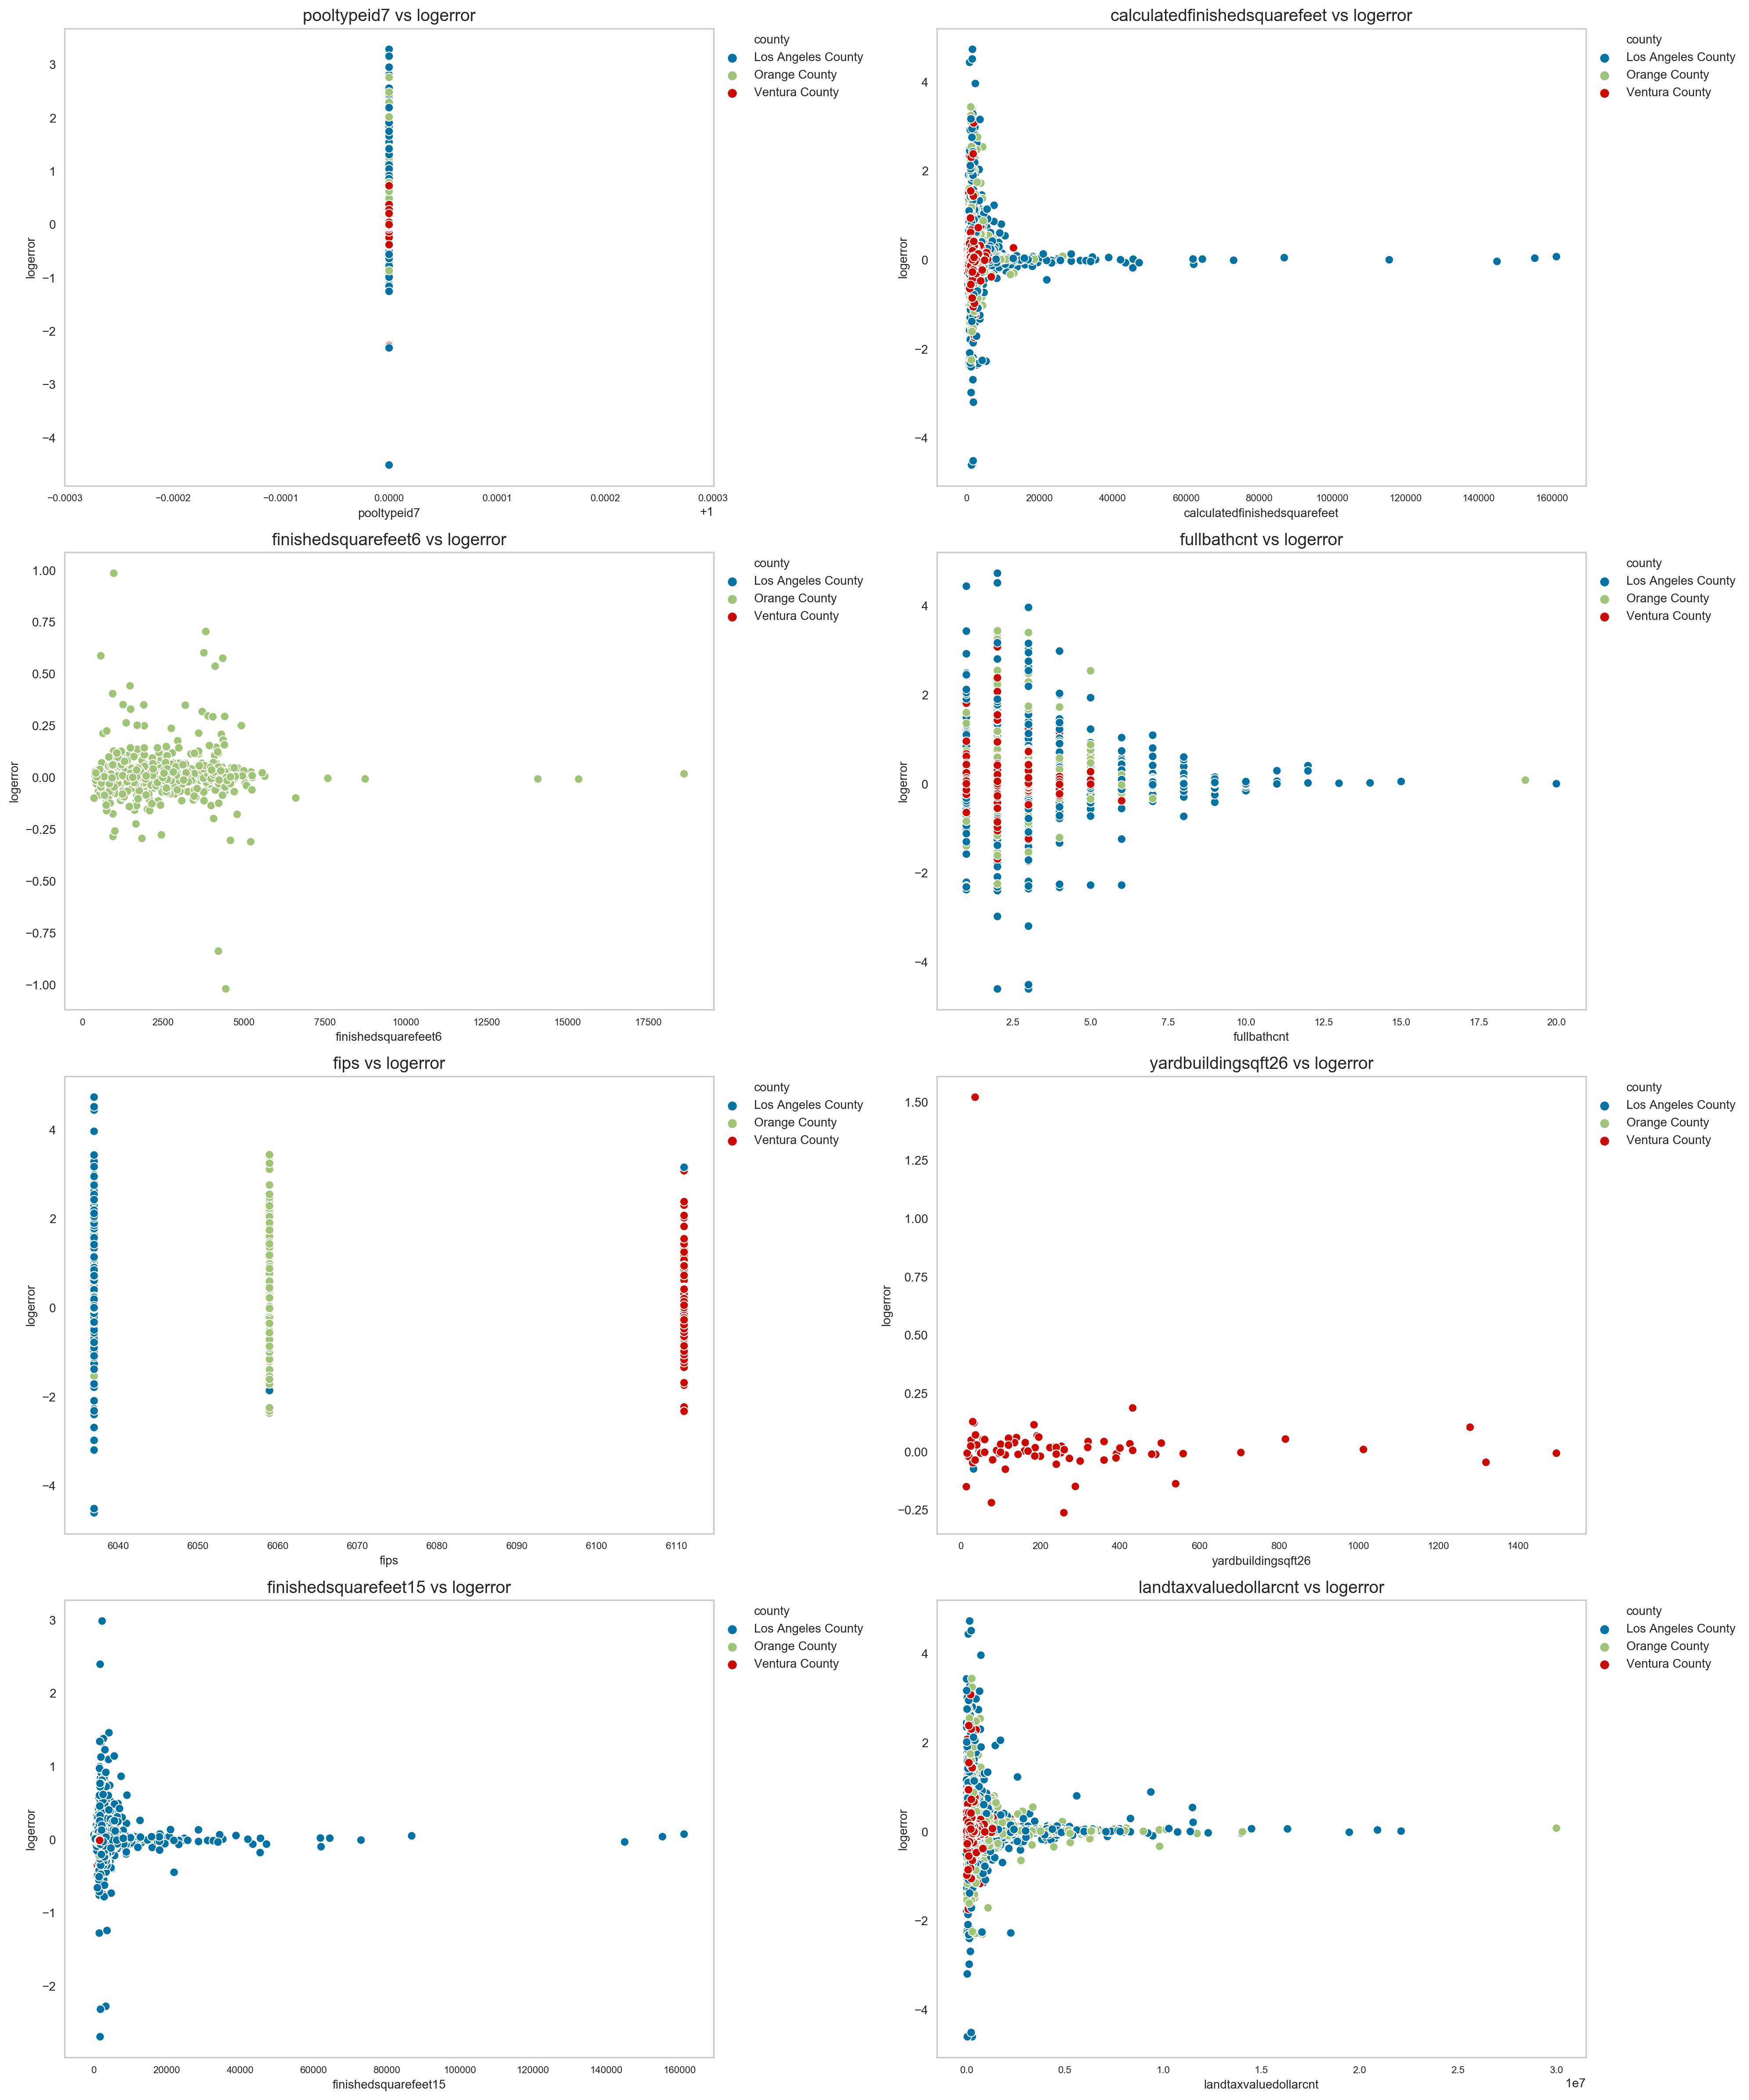

In [10]:
# feature count minus one due to 
plots_per_block = 8

def plot_scatter(columns, col_count=2):
    feature_count = len(columns)
    row_count = math.ceil(float(feature_count) / col_count)

    # print(col_count ,row_count, df.columns)
    fig, axes = plt.subplots(row_count, col_count, figsize = (20,24), dpi = 200)

    n_iter = 16
    axes = np.ravel(axes)
    for i, col_name in enumerate(columns):
        ax = axes[i]
        # beautiful plots referenced: https://imaddabbura.github.io/post/kmeans_clustering/
        sns.scatterplot(x=col_name, y='logerror', data=df, hue = 'county', ax = ax)
        ax.set_xlabel(col_name, fontsize = 10)
        ax.set_ylabel('logerror', fontsize = 10)
        ax.set_title('{0} vs logerror'.format(col_name), fontsize = 14)
        ax.tick_params(axis='x', labelsize=8)
        legend = ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.1, fontsize=10)
        ax.grid()

    plt.tight_layout()

starting_idx = 0
stopping_idx = starting_idx + plots_per_block

def inc_idx():
    global starting_idx
    global stopping_idx
    starting_idx = stopping_idx
    stopping_idx += plots_per_block
    
plot_scatter(continuous_columns[starting_idx:stopping_idx])
inc_idx()


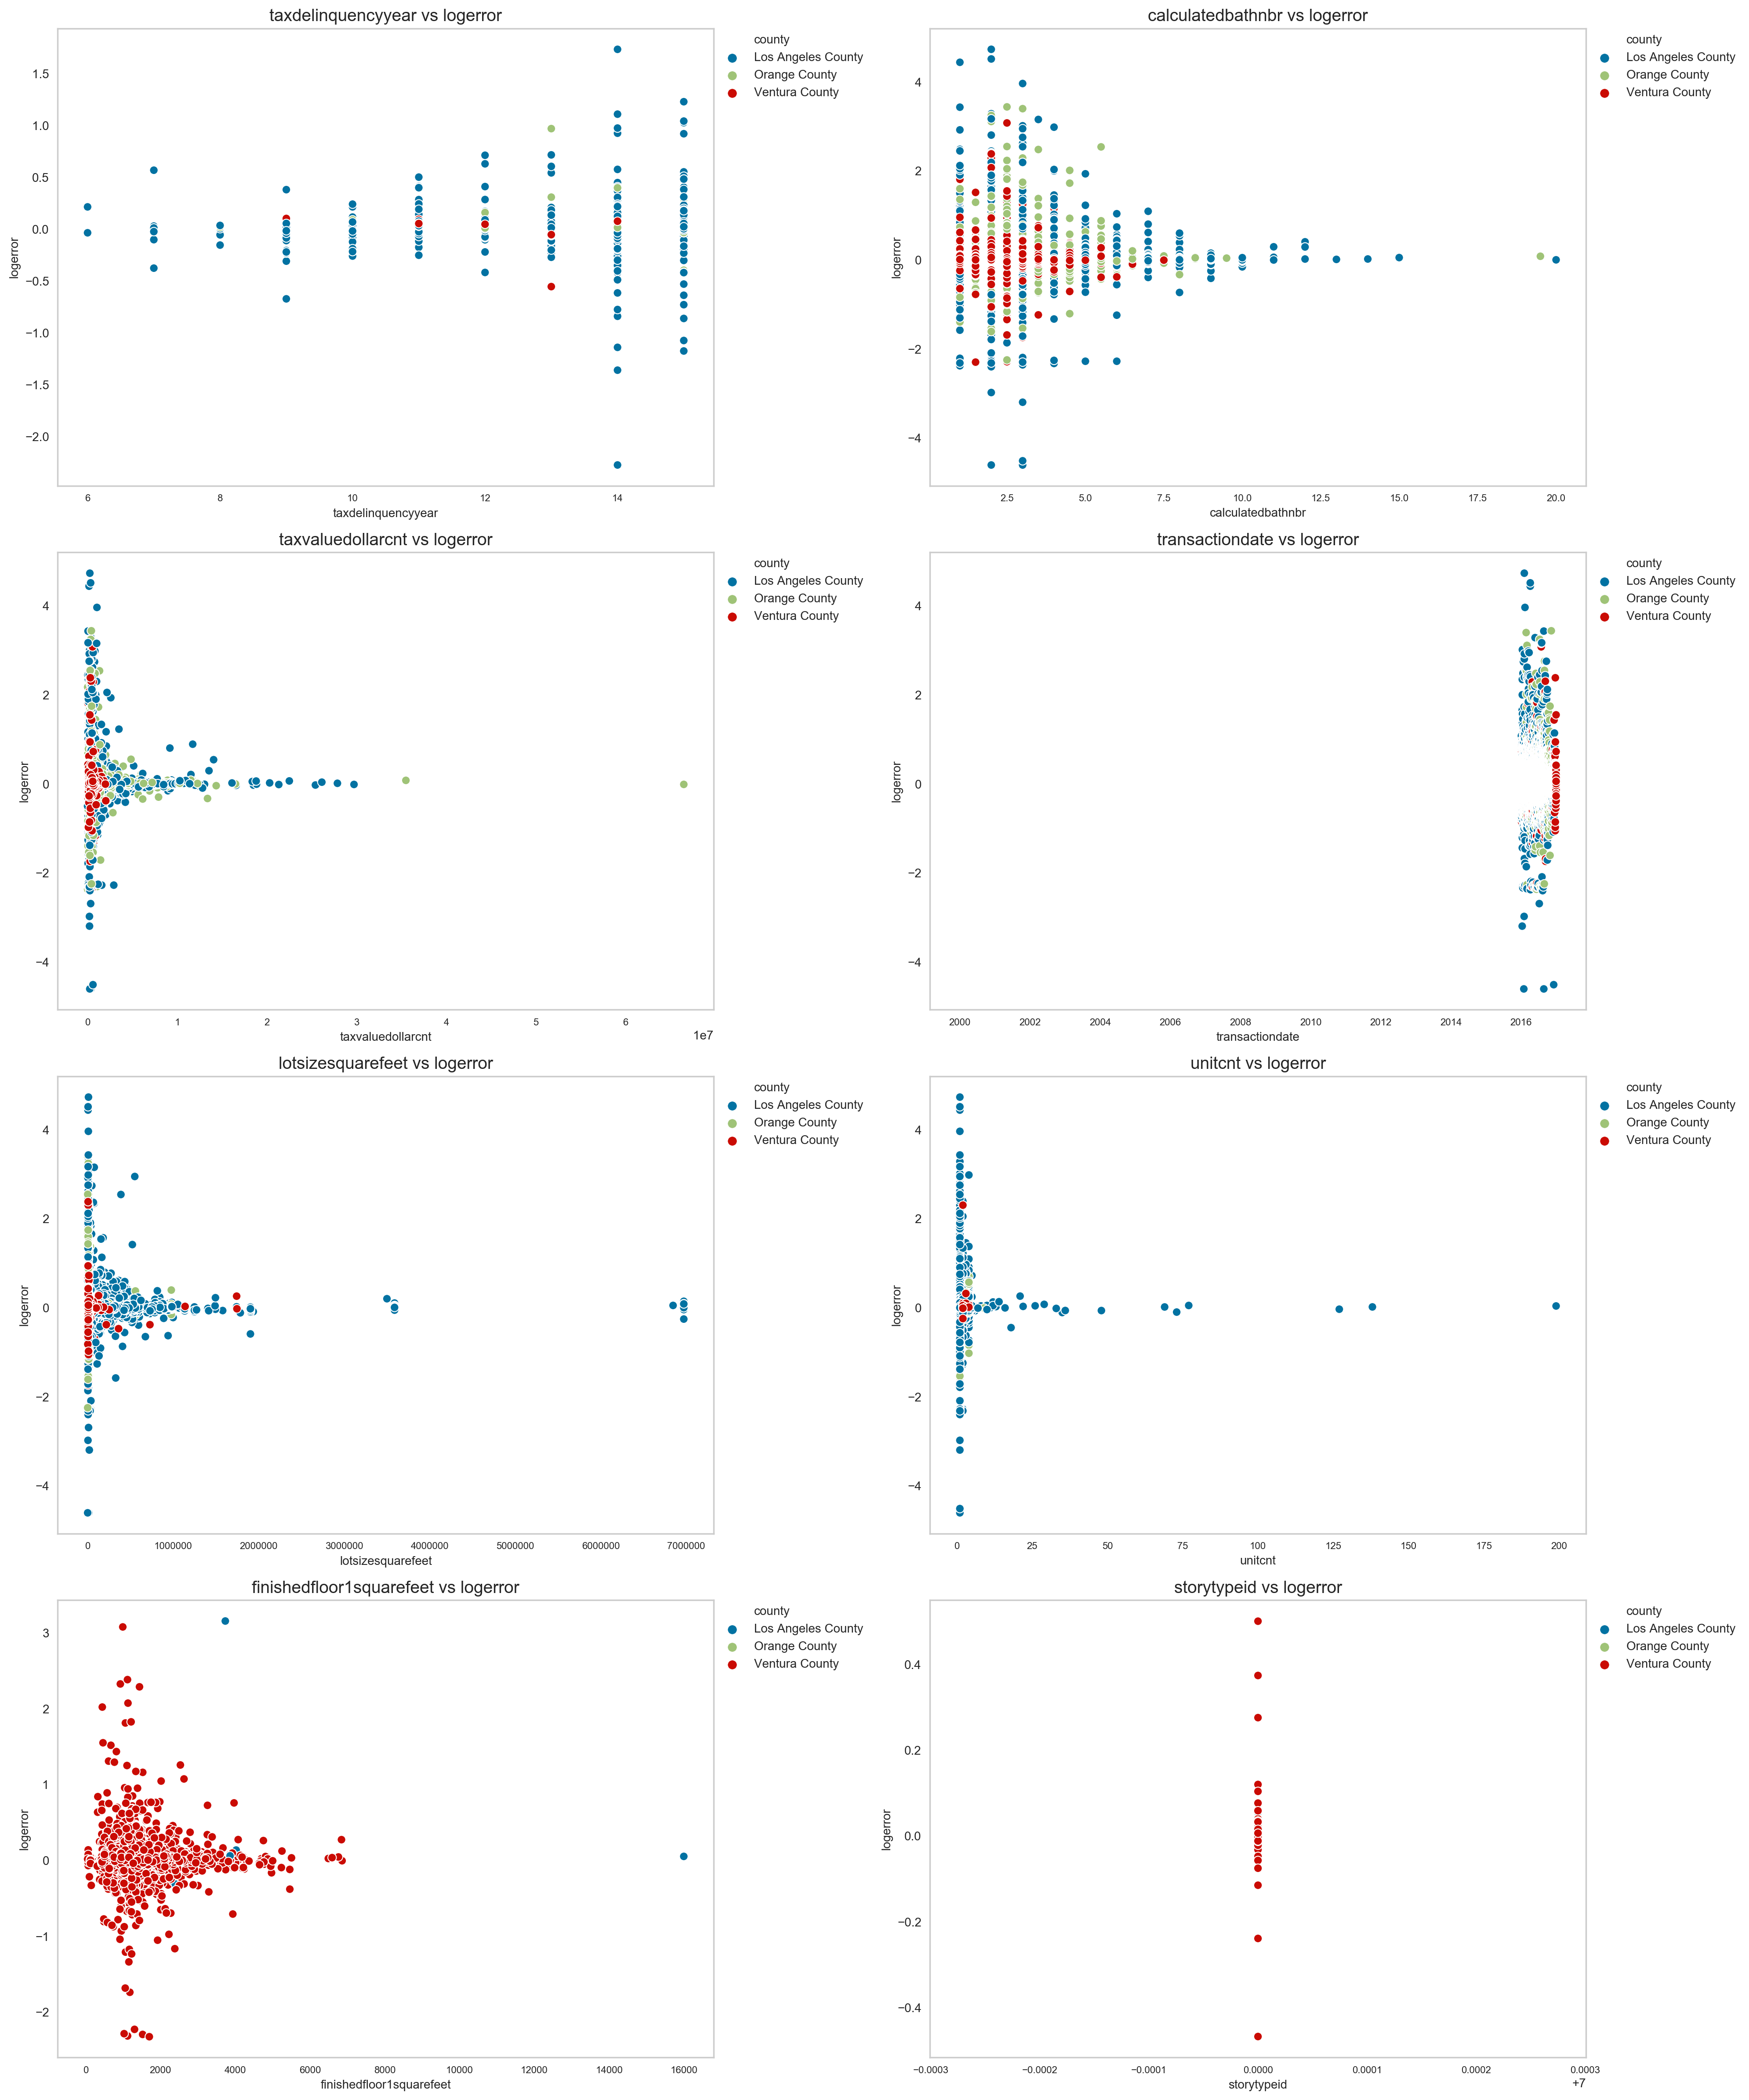

In [11]:
plot_scatter(continuous_columns[starting_idx:stopping_idx])
inc_idx()

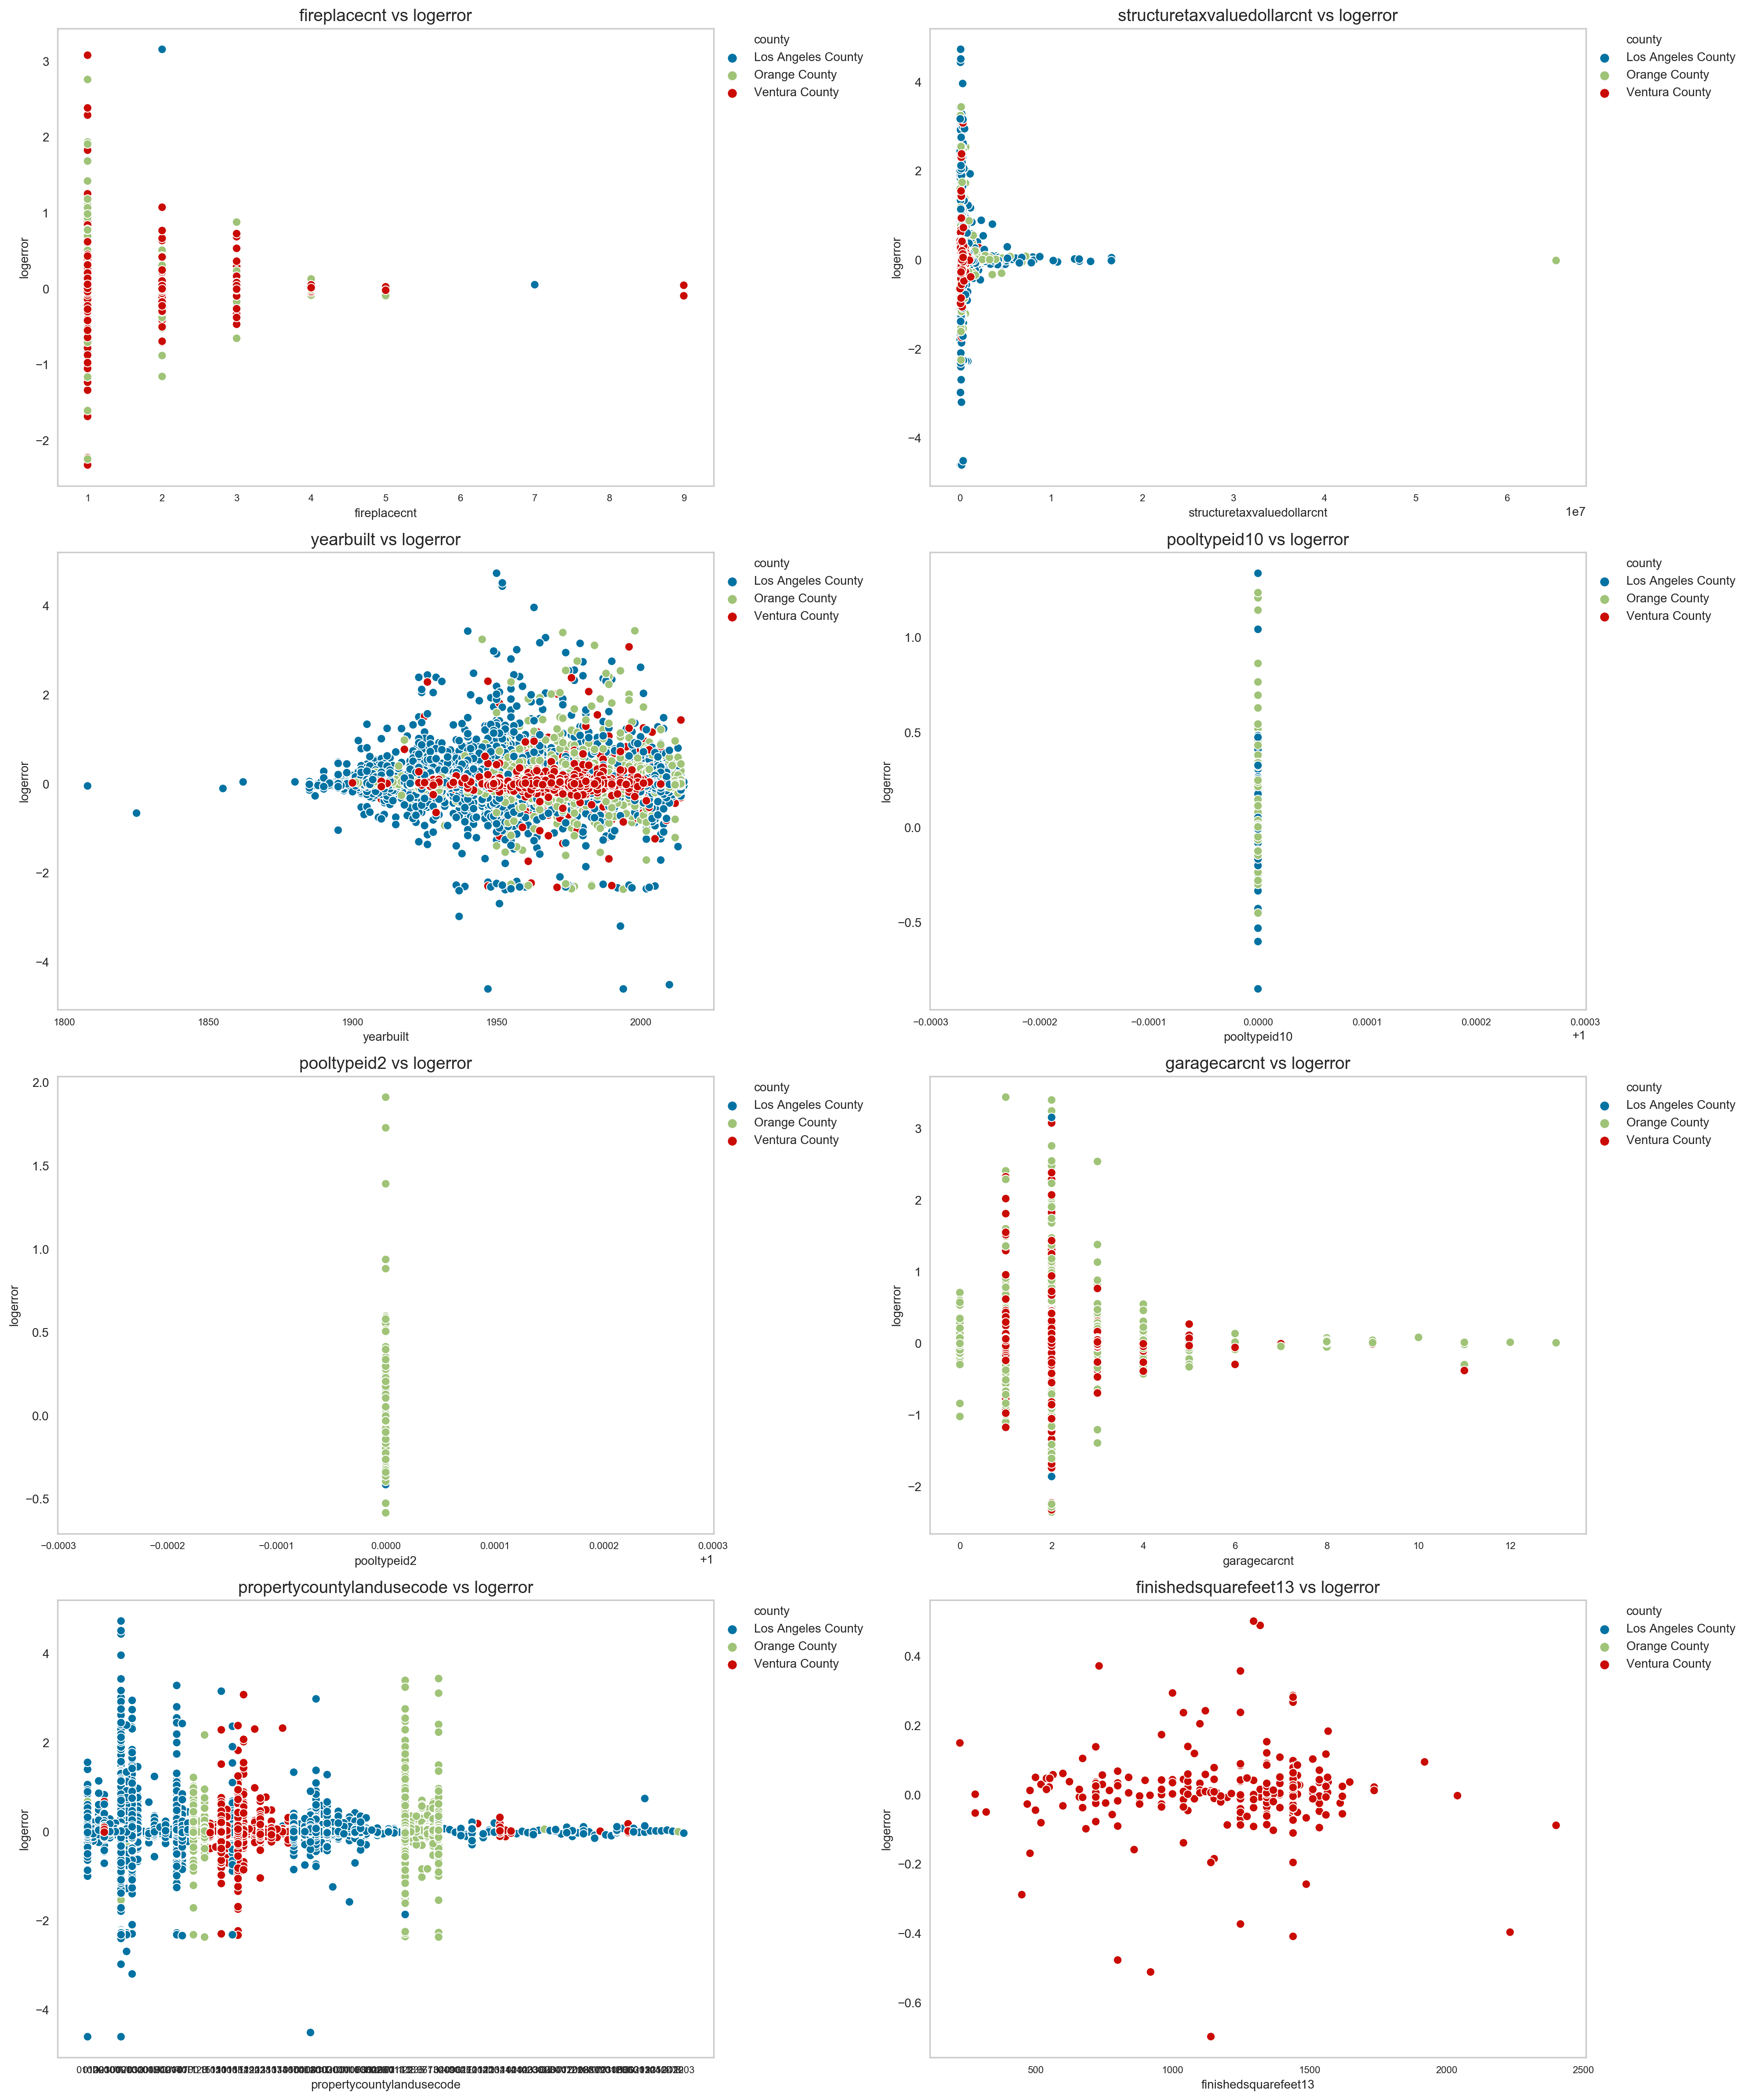

In [12]:
plot_scatter(continuous_columns[starting_idx:stopping_idx])
inc_idx()

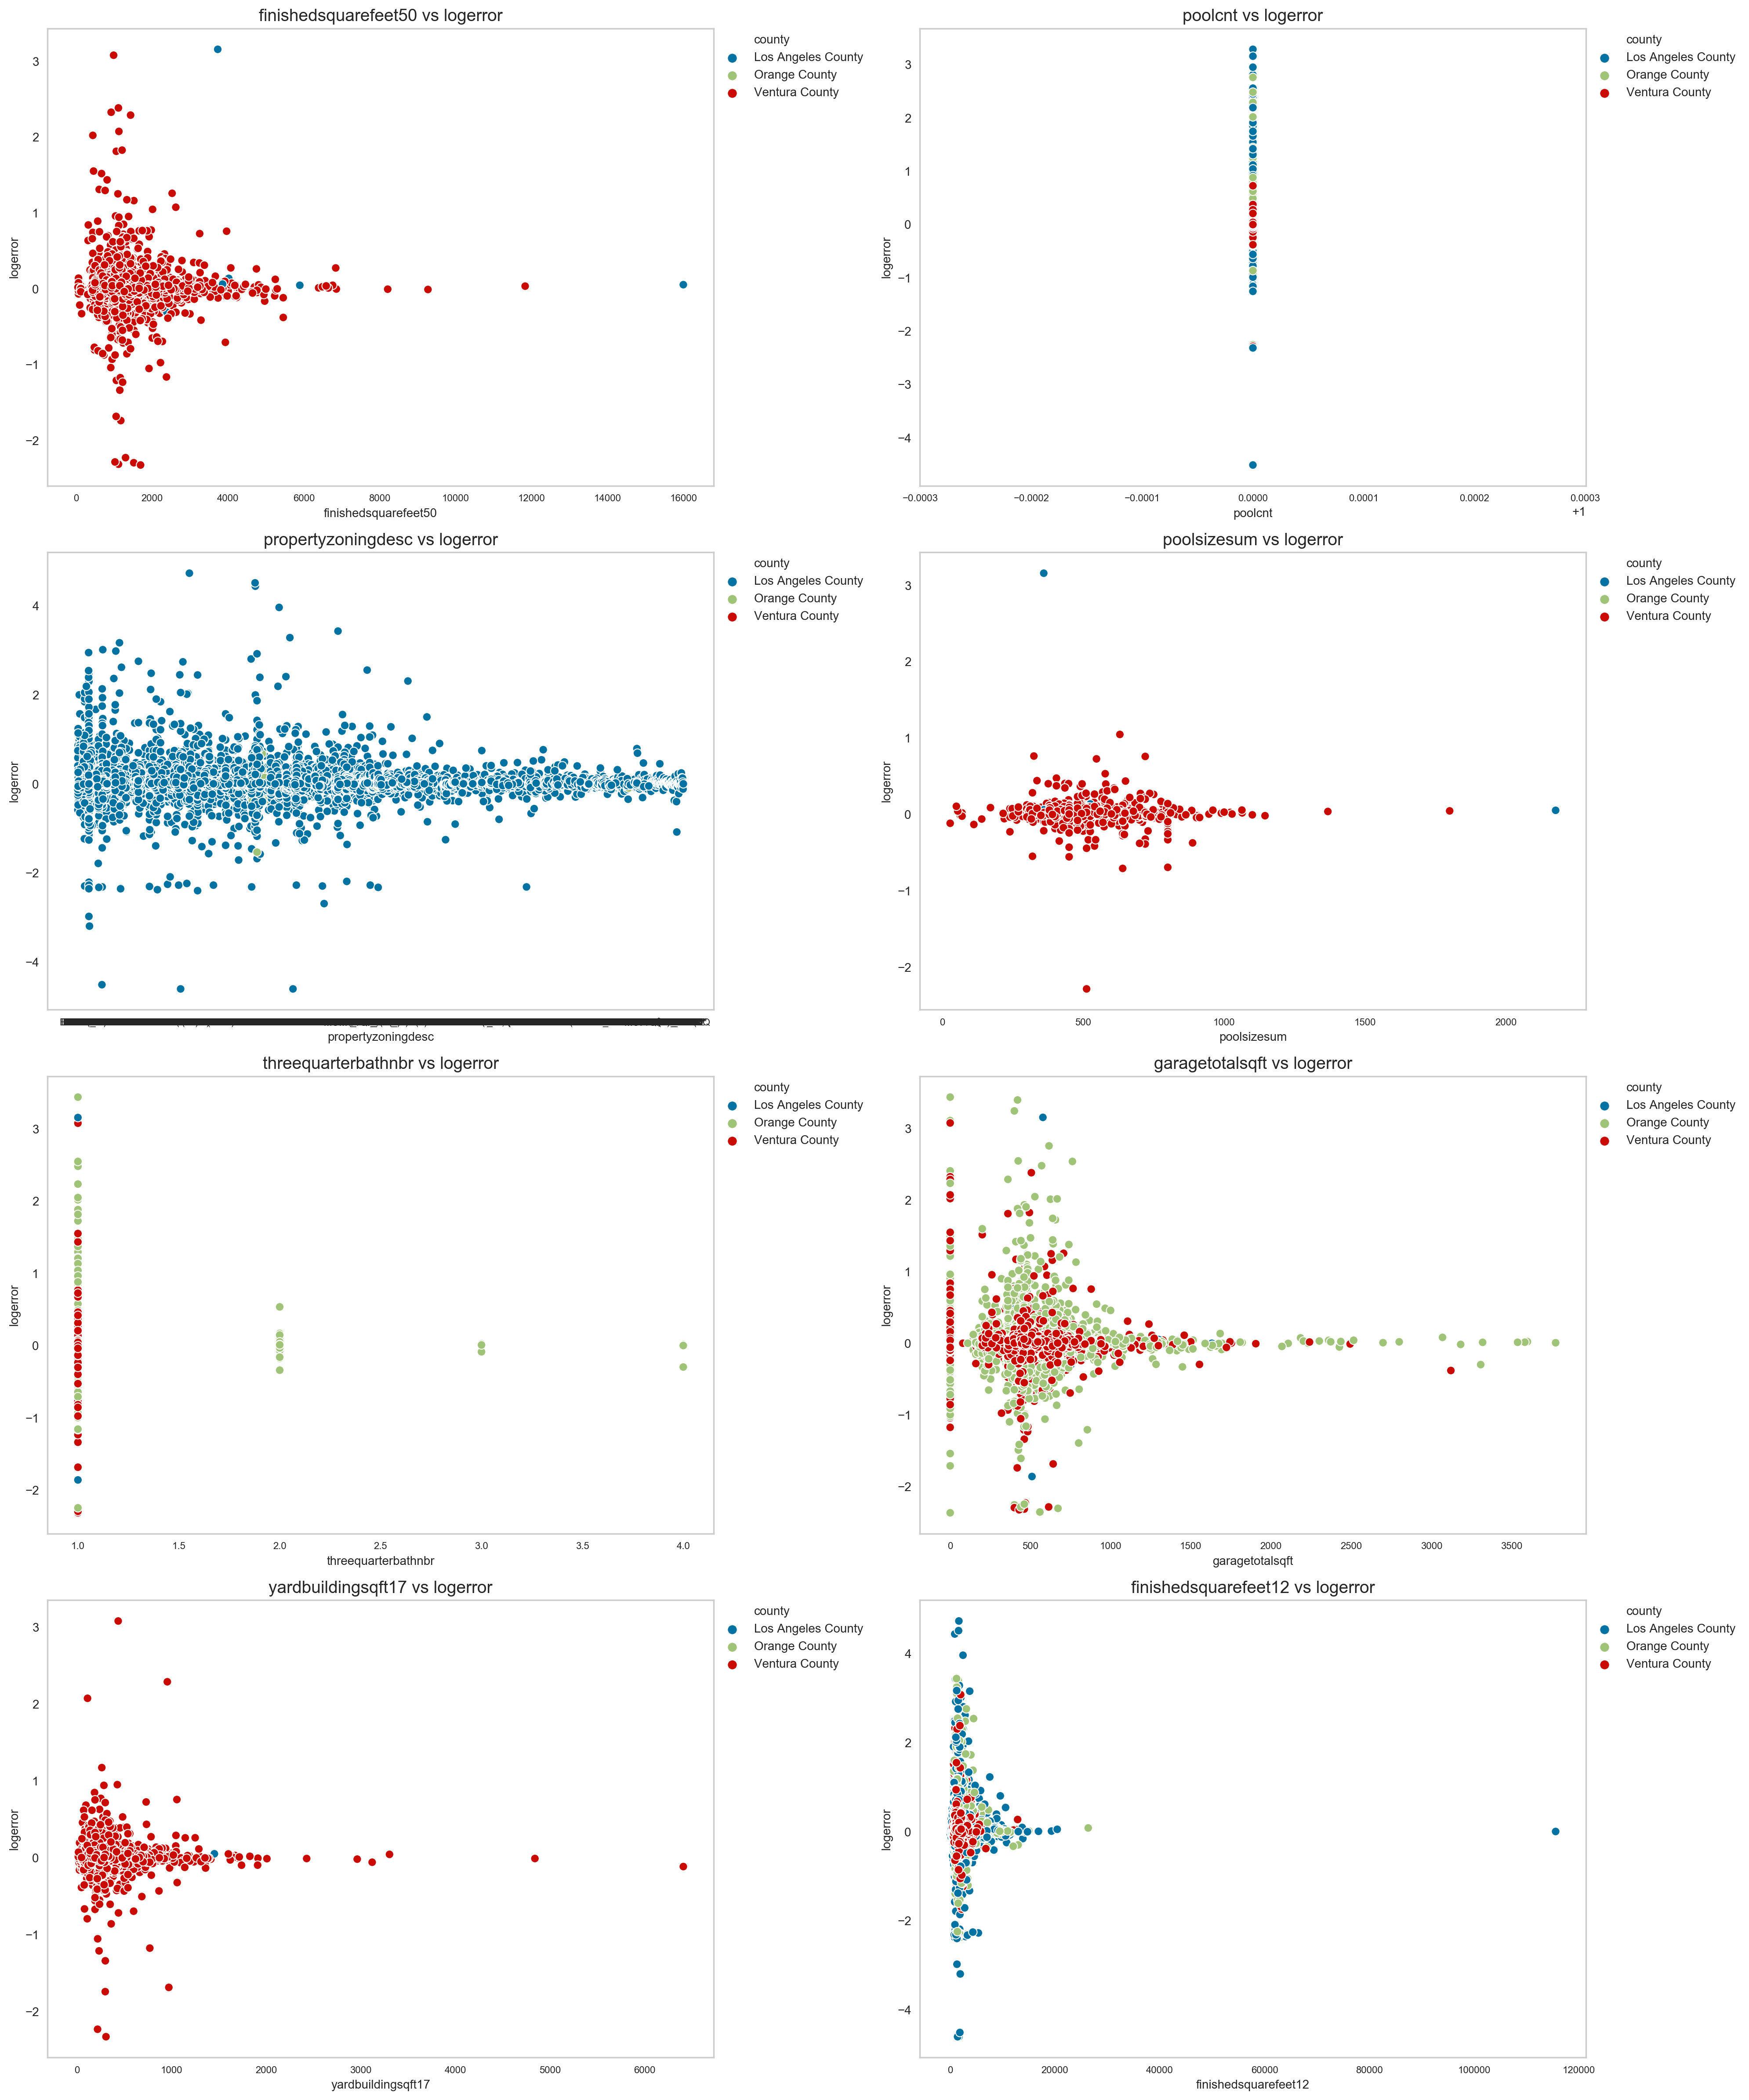

In [13]:
plot_scatter(continuous_columns[starting_idx:stopping_idx])
inc_idx()

In [ ]:
plot_scatter(continuous_columns[starting_idx:stopping_idx])
inc_idx()

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12,10))
df.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')

plt.tight_layout()

#### Drop duplicative data

We've decided to drop the following obviously duplicative columns whose information is better characterized by other variables present in the dataset. 
* fips - a five-digit code which identifies counties and county equivalents in the United States. Can be represented by city and county data pulled in
* storytypeid -  type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.) Can be represented by basementsqft
* calculatedbathnbr - number of bathrooms in home including fractional bathroom. Can be represented by bathroomcnt and bedroomcnt 

In [ ]:
# drop fips, storytypeid, and calcuatedbathnbr
df.drop(labels=['storytypeid','fips', 'calculatedbathnbr'], axis=1,inplace=True)

#### Convert to character format
Now we need to standardize some categorical data from characters to numeric values.

In [ ]:
# standardize and convert data to 1 or 0
def convert_yn(x):
    if x in ['True','Y']:
        return 1
    return 0

for col in ['hashottuborspa','taxdelinquencyflag','fireplaceflag']:
    df[col] = df[col].astype('str').map(convert_yn)

#### Analyze continuous variables

There are likely other variables that will not be helpful in improving model performance. We will first explore the continuous variables to understand their effect on logerror, before making a determination to keep or drop columns 

In [ ]:
# filter only for columns with numeric values

# some of these are actually categorical. Leave for Ray to analyze
# EH - ideally we replace labels = [long list] with categorical_columns above for code simplicity...

numeric_df = df.select_dtypes(include=['float64','int64']).drop(labels=['airconditioningtypeid','architecturalstyletypeid',
                        'buildingclasstypeid','buildingqualitytypeid','heatingorsystemtypeid','latitude','longitude',
                        'propertylandusetypeid','rawcensustractandblock','regionidcity','regionidcounty',
                        'regionidneighborhood','regionidzip','typeconstructiontypeid','censustractandblock',
                        'bathroomcnt','bedroomcnt','assessmentyear', 'roomcnt', 'hashottuborspa','taxdelinquencyflag',
                        'fireplaceflag'], axis=1)


In [ ]:
def analyze_cols(df):
    """ Takes a data frame and for each column calculates the mean and standard 
        deviation of absolute logerror for listings with this home populated 
        as well as without this home populated.
        
        Performs a two-tailed independent t-test to determine if the listings with 
        this column populated have a different logerror than those without it populated.
        
        Returns a dataframe with all values for each column
    """
    out_list = []
    for col in df.columns:
        if col == "logerror":
            continue
            
        my_dict = {}
        
        # Split the df based on whether the col is populated and just keep absolute value of logerror
        pop_df = np.abs(df[(df[col].notna())]['logerror'])
        nan_df = np.abs(df[(df[col].isnull())]['logerror'])

        # Print out the mean and st dev logerror
        my_dict["col"] = col
        my_dict["n"] = pop_df.shape[0]
        my_dict["mean_pop"] = pop_df.mean()
        my_dict["std_pop"] = pop_df.std()
        my_dict["mean_nan"] = nan_df.mean()
        my_dict["std_nan"] = nan_df.std()
        my_dict['p_val'] = stats.ttest_ind(pop_df,nan_df).pvalue
        
        out_list.append(my_dict)
        
    return pd.DataFrame(out_list)[['col','n','mean_pop','mean_nan','std_pop','std_nan','p_val']].sort_values(by="n").set_index('col')

In [ ]:
analyze_cols(numeric_df)

#### Drop columns

Based on above statistical analysis, we decided to drop columns based on the following thresholds: 
* columns that are less than 5% populated (n < 4,507) 
* columns that have a p-value > 0.5

The columns that meet both of these criteria are the following:
* basementsqft
* yardbuildingsqft26
* finishedsquarefeet13
* poolsizesum
* pooltypeid2
* pooltypeid10

In [ ]:
# drop columns that do not meet thresholds for influencing logerror
df.drop(labels=['basementsqft', 'yardbuildingsqft26', 'finishedsquarefeet13', 
                'poolsizesum', 'pooltypeid2', 'pooltypeid10'], axis=1,inplace=True)

# Ray
## Going to convert categorical columns now 

## Not converting the one's we've decided to drop: pooltypeid2, pooltypeid10

## Categorical Columns:

In [ ]:
# # Should we consider just converting this to yes or no ? 1/0.  
# 1	Central Yes
# 2	Chilled Water No
# 3	Evaporative Cooler No
# 4	Geo Thermal? No
# 5	None No
# 6	Other No
# 7	Packaged AC Unit Yes
# 8	Partial No
# 9	Refrigeration Yes?
# 10	Ventilation No?
# 11	Wall Unit Yes
# 12	Window Unit Yes
# 13	Yes Yes
def cat_air(x):
    try:
        if x in [1,7,9,11,12,13]:
            return 'Yes'
        elif x in [2,3,4,5,6,8,10]:
            return 'No'
        else:
            return 'Blank'
    except ValueError:
        return 'Blank'
combined_df['airconditioningtypeid'] = combined_df['airconditioningtypeid'].apply(cat_air)

In [ ]:
display(combined_df['airconditioningtypeid'].value_counts())

In [ ]:
print(combined_df.groupby(['county','airconditioningtypeid']).count()['county_city'])

In [ ]:
# HeatingOrSystemTypeID	HeatingOrSystemDesc
# 1	Baseboard 
# 2	Central 
# 3	Coal
# 4	Convection
# 5	Electric
# 6	Forced air
# 7	Floor/Wall
# 8	Gas
# 9	Geo Thermal
# 10	Gravity
# 11	Heat Pump
# 12	Hot Water
# 13	None
# 14	Other
# 15	Oil
# 16	Partial
# 17	Propane
# 18	Radiant
# 19	Steam
# 20	Solar
# 21	Space/Suspended
# 22	Vent
# 23	Wood Burning
# 24	Yes
# 25	Zone
def cat_heat(x):
    try:
        if x in [1,2,3,4,5,6,7,8,9,11,12,15,16,17,18,19,20,21,22,23,24,25]:
            return 'Yes'
        elif x in [10,13,14]:
            return 'No'
        else:
            return 'Blank'
    except ValueError:
        return 'Blank'
combined_df['heatingorsystemtypeid'] = combined_df['heatingorsystemtypeid'].apply(cat_heat)
print(combined_df.groupby(['county','heatingorsystemtypeid']).count()['county_city'])

In [ ]:
# PropertyLandUseTypeID	PropertyLandUseDesc
# 31	Commercial/Office/Residential Mixed Used
# 46	Multi-Story Store
# 47	Store/Office (Mixed Use)
# 246	Duplex (2 Units, Any Combination)
# 247	Triplex (3 Units, Any Combination)
# 248	Quadruplex (4 Units, Any Combination)
# 260	Residential General
# 261	Single Family Residential
# 262	Rural Residence
# 263	Mobile Home
# 264	Townhouse
# 265	Cluster Home
# 266	Condominium
# 267	Cooperative
# 268	Row House
# 269	Planned Unit Development
# 270	Residential Common Area
# 271	Timeshare
# 273	Bungalow
# 274	Zero Lot Line
# 275	Manufactured, Modular, Prefabricated Homes
# 276	Patio Home
# 279	Inferred Single Family Residential
# 290	Vacant Land - General
# 291	Residential Vacant Land
# def propertylandusetypeid(x):
#     try:
#         if x in [1,2,3,4,5,7,8,9,11,12,15,16,17,18,19,20,23,24]:
#             return 'Yes'
#         elif x in [6,10,13,14,21,22,25]:
#             return 'No'
#         else:
#             return 'Blank'
#     except ValueError:
#         return 'Blank'
# combined_df['propertylandusetypeid'] = combined_df['propertylandusetypeid'].apply(cat_heat)
print(combined_df.groupby(['county','propertylandusetypeid']).count()['county_city'])

In [ ]:
#Covert this to high quality, medium, low?  (Range is from 1-12)

def cat_qual(x):
    try:
        if x <=4:
            return 'High'
        elif x <=8:
            return 'Medium'
        else:
            return 'Low'
    except ValueError:
        return 'Blank'
combined_df['buildingqualitytypeid'] = combined_df['buildingqualitytypeid'].apply(cat_qual)

print(combined_df.groupby(['county','buildingqualitytypeid']).count()['county_city'])


In [ ]:
#We want to remove architecturalstyletypeid (170 records) and typeconstructiontypeid (201 records) and buildingclasstypeid (440 records)

print(combined_df.groupby(['county','architecturalstyletypeid']).count()['county_city'])

print(combined_df.groupby(['county','typeconstructiontypeid']).count()['county_city'])

print(combined_df.groupby(['county','buildingclasstypeid']).count()['county_city'])

### Columns to drop: architecturalstyletypeid (170 records) and typeconstructiontypeid (201 records) and buildingclasstypeid (440 records). Drop latitude, longitude we have used it to map already. (Unless we want to try to use that somehow later)

In [ ]:
print(combined_df.groupby(['county','roomcnt']).count()['county_city'])


### We will also drop census tract information. Doesn't tell us anything interesting. 
### Definition: A Census Block Group is a geographical unit used by the United States Census Bureau which is between the Census Tract and the Census Block. It is the smallest geographical unit for which the bureau publishes sample data, i.e. data which is only collected from a fraction of all households.

### Fireplace flag only has 149 actual homes that have a fire place flag. Will that matter much? Keep for now. Idk what homes in CA even have fire places... lol

### I'm going to remove the record with 86 rooms in OC. It's way too ridiculous. See above. Keep roomcnt as a variable, but make it exponential? not sure. Once standardized it might not matter.

In [ ]:
print(len(combined_df))
combined_df = combined_df[combined_df['roomcnt'] != 86.0]
print(len(combined_df))

In [ ]:
print(combined_df.groupby(['county','bathroomcnt']).count()['county_city'])

In [ ]:
print(combined_df.groupby(['county','bedroomcnt']).count()['county_city'])

## Going to treat roomcnt, bedroomcnt, bathroomcnt as continuous and not remove them in categorical separation. PCA will probably handle that linear relationship b/w those rooms.

In [ ]:
print(combined_df.groupby(['county','assessmentyear']).count()['county_city'])

## Removing assessment year, no useful information and dominantly 2015.

In [ ]:
combined_df['regionidcounty'].head(5)

In [ ]:
## Below print just tells us total columns I should be analyzing to make sure I don't miss anything.
##Can remove if everyone is okay w/ my work

In [ ]:
total_col = combined_df.columns
numeric_col = numeric_df.columns
missing_col = []
for x in total_col:
    if(x in numeric_df.columns):
        None
    else:
        missing_col.append(x)
        
print(missing_col)

## Save normalization/interoplation for after we analyze which columns have the most variation

In [ ]:
# interpolate missing values for the following columns
#interpolate_columns = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', \
#                      'landtaxvaluedollarcnt', 'taxamount', 'lotsizesquarefeet', \
#                      'garagetotalsqft']

# default interpolation method is linear, let's just stick with that
#for column in interpolate_columns:
#    combined_df[column].interpolate(inplace=True)

In [ ]:
# Commenting out for now - will normalize instead of using log transform
# transform columns with very large st dev to log
#log_transform_columns = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', \
#                        'taxamount', 'lotsizesquarefeet']

#eps = 1e-6
#for column in log_transform_columns:
#    combined_df[column] = np.log10(combined_df[column] + eps)


In [ ]:
# normalize continuous variables
#normalize_columns = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'garagetotalsqft', \
#                     'lotsizesquarefeet', 'poolsizesum', 'yardbuildingsqft17', \
#                    'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt',
#                    'taxamount']


#for column in normalize_columns:
#    combined_df[column] = (combined_df[column] - combined_df[column].mean()) / combined_df[column].std()

## Train Data EDA

## Transaction Counts and Avg logerror by Month

In [ ]:
# plot logerrors over time
plt_df = combined_df[['transactiondate','logerror']].copy()
plt_df['transactiondate'] = plt_df.transactiondate#.astype('datetime64[M]')
plt_df['logerror'] = np.abs(plt_df.logerror)
g = plt_df.groupby(['transactiondate']).mean()
g.plot()
plt.title("Mean abs(logerror) vs Transaction Date")
plt.show()
plt.hist(plt_df.transactiondate,bins=52)
plt.title("Number of Transactions by Week")
plt.show()

## <font color=red> This is the start of feature exploration, selection, and engineering... </font>

## Split dataset into train, dev, and test and filter to July 2016

In [ ]:
keep = ['airconditioningtypeid','buildingqualitytypeid', 'heatingorsystemtypeid', 
                       'propertylandusetypeid','taxdelinquencyflag', 'county']
border_line = ['fireplaceflag','hashottuborspa']
drop = ['architecturalstyletypeid','buildingclasstypeid','latitude', 'longitude', 'censustractandblock',
        'typeconstructiontypeid', 'assessmentyear', 'regionidcity','regionidcounty','rawcensustractandblock',
                        'regionidneighborhood','regionidzip', 'transactiondate', 'latlng', 'county_city', 'city', 
       'propertycountylandusecode','propertyzoningdesc' ]

In [ ]:
# Set the columns to filter out of the dataset here
excl_cols = ['basementsqft', 'yardbuildingsqft26', 'finishedsquarefeet13', 'poolsizesum', 'pooltypeid2', 'pooltypeid10',
             'calculatedbathnbr']
excl_cols = excl_cols + drop

In [ ]:
# split the dataset into train (60%), dev (20%), and test (20%)
# Set a random seed (623) to keep our dataset consistent between runs
# Only use data from July 2016

df = shuffle(combined_df.copy(deep = True), random_state=623)
if excl_cols is not None:
    df.drop(labels = excl_cols, axis=1, inplace=True)


In [ ]:
df['propertlandusetypeid'] = df_cat['propertylandusetypeid'].apply(str)
df_dummies = pd.get_dummies(df, dummy_na = True)

In [ ]:
df_dummies.columns

In [ ]:
df = df_dummies.copy(deep = True)

In [ ]:

#df = df[(df['transactiondate'] >= '2016-07-01') & (df['transactiondate'] <= '2016-07-31')]

i_logerror = df.columns.get_loc("logerror")

train_data, train_labels = df.iloc[:int(len(df)*0.6), np.r_[0:i_logerror, (i_logerror+1):len(df.columns)]], df.iloc[:int(len(df)*0.6),i_logerror:(i_logerror+1)].values
df_train = df.iloc[:int(len(df)*0.6), :]
dev_data, dev_labels = df.iloc[int(len(df)*0.6):int(len(df)*0.8), np.r_[0:i_logerror, (i_logerror+1):len(df.columns)]], df.iloc[int(len(df)*0.6):int(len(df)*0.8),i_logerror:(i_logerror+1)].values
df_dev = df.iloc[int(len(df)*0.6):int(len(df)*0.8), :]
test_data, test_labels = df.iloc[int(len(df)*0.8):, np.r_[0:i_logerror, (i_logerror+1):len(df.columns)]], df.iloc[int(len(df)*0.8):,i_logerror:(i_logerror+1)].values
df_test = df.iloc[int(len(df)/2):, :]

### Histograms of features in our train dataset

In [ ]:
# Plot bed/bath ratio vs logerror - any difference for outliers
plt.figure(figsize=(8,5))
plt.scatter(df_train.bedroomcnt/df_train.bathroomcnt,df_train.logerror, alpha=0.2)
plt.xlabel('Beds/Baths')
plt.ylabel('Logerror')
plt.title('Logerrors vs Bed/Bath ratio')
plt.show()

In [ ]:
# Plot beds and baths vs logerror - any difference for outliers
plt.figure(figsize=(8,5))
plt.scatter(df_train[np.abs(df_train.logerror)>=0.1].bedroomcnt,df_train[np.abs(df_train.logerror)>=0.1].bathroomcnt,c=df_train[np.abs(df_train.logerror)>=0.1].logerror, cmap=plt.get_cmap('seismic'))
plt.xlabel('Bedrooms')
plt.ylabel('Bathrooms')
plt.title('Logerrors more than +-0.1 by Beds/Baths')
plt.colorbar()
plt.show()

In [ ]:
# plot histograms of Logerrors
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax.flatten()
ax[0].hist(df_train.logerror,bins=40)
ax[0].set_title("Logerror Histogram")
ax[1].hist(df_train.logerror[np.abs(df_train.logerror) >= 0.1],bins=40)
ax[1].set_title("Logerror Histogram, excluding errors between +-0.1")
plt.show()

In [ ]:
# Plot histograms of the columns of interest that aren't binomial or way too many categories
fig, ax = plt.subplots(8,5, figsize=(15,24))
ax = ax.flatten()
i = 0
for c in df_train.iloc[:,0:48].columns:
    if c in ['decktypeid','hashottuborspa','poolcnt','pooltypeid10','pooltypeid2','pooltypeid7','propertyzoningdesc',
             'propertycountylandusecode','regionidcity','regionidcounty','regionidneighborhood','fireplaceflag',
             'censustractandblock','latitude','longitude']:
        continue
    ax[i].hist(df_train[c])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_title(c)
    i+=1

plt.delaxes(ax[39])
plt.tight_layout()
plt.show()

## <font color=green> EH - Trying dimensionality reduction (PCA) on subsets of data </font>
We experiment with using PCA to group similar data (e.g. pool variables into a single dimension) then use the reduced projections moving forward

In [ ]:
df_train.head()

In [ ]:
# double check data types and shape
# df_train.dtypes
# df_train.shape

In [ ]:
# look at different groups of similar variables to understand if possible to combine
sqft = df_train[["finishedfloor1squarefeet", "calculatedfinishedsquarefeet",  "finishedsquarefeet12", "finishedsquarefeet15",
                 "finishedsquarefeet50", "finishedsquarefeet6"]]

garage = df_train[["garagecarcnt", "garagetotalsqft"]]

pool = df_train[["poolcnt", "pooltypeid7"]]

values = df_train[["structuretaxvaluedollarcnt", "taxvaluedollarcnt", "landtaxvaluedollarcnt", "taxamount"]]

region = df_train[["regionidcounty", "regionidcity", "regionidzip", "regionidneighborhood"]]


In [ ]:
# replace NaN values with the mean of each column
sqft = sqft.fillna(sqft.mean())
garage = garage.fillna(garage.mean())
pool = pool.fillna(pool.mean())
values = values.fillna(values.mean())
region = region.fillna(region.mean())

In [ ]:
# project grouped data into 1 dimension
sqft_projected = PCA(n_components = 1).fit_transform(sqft)
garage_projected = PCA(n_components = 1).fit_transform(garage)
values_projected = PCA(n_components = 1).fit_transform(values)
region_projected = PCA(n_components = 1).fit_transform(region)

# probably can't project pool data because the replacement value is all 1, so thre is no point of comparison
pool_projected = PCA(n_components = 1).fit_transform(pool)


## PCA with un-transformed data

First, create a subset that excludes the non-numeric variables. PCA only works well on continuous variables.

In [ ]:
pca_train_data = train_data.select_dtypes(include=['float64','int64'])
pca_train_data.dtypes

We'll also exclude categorical variables, since PCA explains variance and a category ID of 9 is likely just as different from an ID of 2 as it is an ID of 8.

In [ ]:
pca_train_data.drop(labels=['airconditioningtypeid','architecturalstyletypeid','buildingclasstypeid',
                            'buildingqualitytypeid','decktypeid','heatingorsystemtypeid','propertylandusetypeid',
                           'rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood',
                           'regionidzip','typeconstructiontypeid','censustractandblock','pooltypeid7'], axis=1, inplace=True)

Fill all NaNs accordingly. Some will make sense to set to another column, or set to the mean; others should just be zero.

In [ ]:
# These should be set to zero if they aren't populated - they likely don't exist
for col in ['calculatedfinishedsquarefeet','fireplacecnt','fullbathcnt',
           'garagecarcnt','garagetotalsqft','poolcnt','threequarterbathnbr',
            'yardbuildingsqft17','taxdelinquencyyear']:
    pca_train_data[col].fillna(0, inplace=True)
    
# Set unitcnt and number of stories to 1 if NaN
pca_train_data['unitcnt'].fillna(1,inplace=True)
pca_train_data['numberofstories'].fillna(1,inplace=True)

# Fill these with calculatedfinishedsquarefeet if they don't exist
for col in ['finishedfloor1squarefeet','finishedsquarefeet12','finishedsquarefeet15',
           'finishedsquarefeet50','finishedsquarefeet6','lotsizesquarefeet']:
    pca_train_data[col].fillna(pca_train_data['calculatedfinishedsquarefeet'], inplace=True)
    
# For the tax info, if the land value = total value, set structure NaN to 0 (it's just a lot)
combined_df[(combined_df["taxvaluedollarcnt"] == 
             combined_df["landtaxvaluedollarcnt"])][["structuretaxvaluedollarcnt"]].fillna(0, inplace=True)

# Now set every other NaN to the mean, since we don't have a better guess
for col in ['yearbuilt', 'structuretaxvaluedollarcnt','taxvaluedollarcnt',
           'landtaxvaluedollarcnt','taxamount']:
    pca_train_data[col].fillna(pca_train_data[col].mean(), inplace=True)



Now normalize the columns

In [ ]:
for col in pca_train_data.columns:
    pca_train_data[col] = (pca_train_data[col] - pca_train_data[col].mean()) / pca_train_data[col].std()

In [ ]:
# Run PCA for all components
pca = PCA()
pca.fit(pca_train_data) 

# Create a cumulative line plot of the explained variance ratio for each of the principal components
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Cumulative Explained Variance')
plt.xlabel('Principle component (k)')
plt.ylabel('Explained Variance Ratio')
plt.show()

Looks like PCA with ~20 components retains nearly 100% of variance. This would reduce our number of features by 11. 

In [ ]:
pca = PCA(n_components = 20).fit(pca_train_data)
pca_20_train = pca.transform(pca_train_data)

## Run Models

In [ ]:
import importlib
importlib.reload(gauntlet)

### Models on Ellie's PCA outputs

In [ ]:
def concat_tables(*args):
    out_arr = []
    for arg in args:
        arg_np = np.array(arg)
        out_arr.append(arg_np)
        
    return np.concatenate(out_arr, axis=1)

full_data = concat_tables(sqft, garage, values, region)
projected_data = concat_tables(sqft_projected, garage_projected, values_projected, region_projected)
labels = df_train['logerror']

In [ ]:
gauntlet.compare_datasets(full_data, labels, projected_data, labels)

In [ ]:
from sklearn.neural_network import MLPRegressor
err_, err_std_ = gauntlet.cross_validate(MLPRegressor, full_data, labels)
print(f'MLP Error: {err_:.3f}, Error std: {err_std_:.2f}')

It looks like the MLPRegressor is just bad. Maybe this could be improved via fiddling with the network architecture?

In [ ]:
# first let's try our rule of thumb
num_in_and_out = int((full_data.shape[1] + 1) * (2/3))
err_, err_std_ = gauntlet.cross_validate(MLPRegressor, full_data, labels, hidden_layer_sizes=[num_in_and_out, 5], max_iter=1000)
print(f'MLP Improved Error: {err_:.3f}, Error std: {err_std_:.2f}')

That's a definite improvement. What if we tried it with the smaller data? Note that we are keeping the network architecture consistent.

In [ ]:
err_, err_std_ = gauntlet.cross_validate(MLPRegressor, projected_data, labels, hidden_layer_sizes=[num_in_and_out, 5], max_iter=1000)
print(f'MLP Improved Error: {err_:.3f}, Error std: {err_std_:.2f}')

Nope, still pretty bad. Now let's take a look at Gradient Boosting Trees, as this appears to have performed pretty well.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gauntlet.viz_model(GradientBoostingRegressor, full_data, labels)

It is very interesting that the training score decreases sharply as the amount of training data increases. This appears to indicate noise in the training data. The other thing that is immediately noticable in the prediction error plot is how grouped together the errors are around 0. Let's see what happens with the reduced dataset

In [ ]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())
# gauntlet.viz_model(GradientBoostingRegressor, projected_data, labels)

### Models with 20-component PCA model vs full numerical dataset (31 features)

In [ ]:
gauntlet.compare_datasets(pca_train_data, labels, pca_20_train, labels)

Try GBT with the 20-component PCA

In [ ]:
gauntlet.viz_model(GradientBoostingRegressor, pca_20_train, labels)

In [ ]:
gauntlet.viz_model(GradientBoostingRegressor, pca_train_data, labels)

## t-SNE Clustering
We perform t-SNE clustering to identify if there is a visible grouping of higher `logerror`s. While t-SNE is not great for hard analysis, it is a good visualization utility and would allow us to identify if there is a clear grouping of variables with larger logerrors

In [ ]:
df_train.columns

In [ ]:
# remove categorical variables for now
# AB - removed censustractandblock, rawcensustractandblock, and binary features (hashottuborspa, fireplaceflag, taxdelinquincyflag)
tsne_train_columns = [
       'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'lotsizesquarefeet', 'poolcnt', 'roomcnt',
       'threequarterbathnbr', 'unitcnt',
       'yardbuildingsqft17', 'yearbuilt', 
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 
       'taxdelinquencyyear', 'logerror',
       'transactiondate']
tsne_train_df = df_train[tsne_train_columns].copy()

tsne_train_df['transactiondate'] = tsne_train_df['transactiondate'].astype(np.int64)

drop_columns = []
for column in tsne_train_df.columns:
    if (~tsne_train_df[column].isna()).sum() > 5000:
        # Normalize all features here
        if column != 'logerror':
            tsne_train_df[column] = (tsne_train_df[column] - tsne_train_df[column].mean()) / tsne_train_df[column].std()
        continue
    
    drop_columns.append(column)
tsne_train_df.drop(drop_columns, axis='columns', inplace=True)


#tsne_train_df['transactiondate'] = (tsne_train_df['transactiondate'] - tsne_train_df['transactiondate'].mean()) / tsne_train_df['transactiondate'].std()
#tsne_train_df['assessmentyear'] = (tsne_train_df['assessmentyear'] - tsne_train_df['assessmentyear'].mean()) / tsne_train_df['assessmentyear'].std()
tsne_train_df.dropna(axis='rows', inplace=True)

tsna_train_np = tsne_train_df.loc[:,tsne_train_df.columns != 'logerror']
### WARNING!!! THIS TAKES A WHILE!!!
tsne_results = TSNE(n_components=2, verbose=1).fit_transform(tsna_train_np)

In [ ]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha = .8, c = np.abs(tsne_train_df['logerror']), cmap = 'inferno')
cbar = plt.colorbar()

As we saw in the earlier `logerror` distribution, a very large portion of the logerrors are extremely close to 0, making the colormapping difficult to understand. Let's observe the values both in and outside of these limits

In [ ]:
# filter out high logerrors
mask = np.abs(tsne_train_df['logerror']) < 0.1
tsne_train_df_sub = tsne_train_df[mask]
tsne_results_sub = tsne_results[mask]

plt.figure(figsize=(16,10))
plt.scatter(tsne_results_sub[:,0], tsne_results_sub[:,1], alpha = .8, c = np.abs(tsne_train_df_sub['logerror']), cmap = 'inferno')
cbar = plt.colorbar()

In [ ]:
# filter out low logerrors
mask = np.abs(tsne_train_df['logerror']) > 0.1
tsne_train_df_sub = tsne_train_df[mask]
tsne_results_sub = tsne_results[mask]

plt.figure(figsize=(16,10))
plt.scatter(tsne_results_sub[:,0], tsne_results_sub[:,1], alpha = .8, c = np.abs(tsne_train_df_sub['logerror']), cmap = 'inferno')
cbar = plt.colorbar()

Unfortunately it doesn't look like there is a very large tendency for clusters to have similar logerror values, which means that this task will be pretty difficult. One very interesting thing to note is the linearity in the clusters that were created. Typically these clusters are both long and fat, but in this distribution it appears to be very tight and skinny. I'm not sure what this indicates.

In [ ]:
# AB  - crazy thought - what if we take the log(logerror) to better visualize?
#mask = np.abs(tsne_train_df['logerror']) < 0.1
tsne_train_df_sub = tsne_train_df #[mask]
tsne_results_sub = tsne_results #[mask]

plt.figure(figsize=(16,10))
plt.scatter(tsne_results_sub[:,0], tsne_results_sub[:,1], alpha = .8, c = -np.log(np.abs(tsne_train_df_sub['logerror'])), cmap = 'inferno')
cbar = plt.colorbar()